# Using DIPZ

In [1]:
"""
Using dipz with keras
"""
#'Take only this many inputs (with no args %(const)s)'
_h_take_first = 'Take only this many inputs (with no args %(const)s)'  

# TODO: clean up these hardcoded values
MASK_VALUE = 999
MERGED_NODES = [32]*4

# local libs
from layers import Sum
from utils import gaussian_loss
from utils import TRANSFORMS
from utils import scale
from utils import renamed
from utils import build_feature
from utils import get_gaussian_loss_prec

# mlearnin libs
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, TimeDistributed, Input, Concatenate, Masking
)
#from keras.utils.generic_utils import CustomMaskWarning

# the data libs
import h5py
import json

# random python utility libs
from argparse import ArgumentParser
from pathlib import Path
import warnings

# A function to define and gets the config file 
def get_config(config_path):
    with open(config_path) as cfg:
        config = json.load(cfg)
    return dict(
        jetfeatnames=config["jetfeatnames"],
        trackfeatnames=config["trackfeatnames"],
        targetfeatnames=config["targetfeatnames"],
        batch_size=config["batch_size"],
        epoch_size=config["epoch_size"],
        number_epochs=config["number_epochs"],
        learning_rate=config["lr"],
        tracknodes=config['tracknodes'],
        jetnodes=config['jetnodes'],
    )

# A function that defines and gets the neural network model
def get_model(config, mask_value):
    n_track_inputs = len(config['trackfeatnames'])
    track_inputs = Input(shape=(None,n_track_inputs))

    n_jet_inputs = len(config['jetfeatnames'])
    jet_inputs = Input(shape=(n_jet_inputs))

    # add jet layers
    x = jet_inputs
    for nodes in config['jetnodes']:
        x = Dense(units=nodes, activation='relu')(x)
    jet_latent = x

    # add track layers
    x = track_inputs
    x = Masking(mask_value=mask_value)(x)
    for nodes in config['tracknodes']:
        x = TimeDistributed(Dense(nodes, activation='relu'))(x)
    x = Sum()(x)
    track_latent = x

    # merge the layers
    merged = Concatenate()([jet_latent, track_latent])
    # todo: not clear how many additonal processing layers we should
    # add here
    x = merged
    for nodes in MERGED_NODES:
        x = Dense(nodes, activation='relu')(x)
    out_latent = x
    outputs = keras.layers.Dense(units=2)(out_latent)
    model = keras.Model(
        inputs=[jet_inputs, track_inputs],
        outputs=outputs)
    # print the summary
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=gaussian_loss)
    return model

# A function that imports the dataset we will be working on
def get_dataset(h5file_path, config, mask_value, take_first=False):
    """
    We make some hardcoded transformations to normalize these inputs
    """

    # pt is log transformed
    # Z0 is divided by 50
    # target is divided by 50

    trf = TRANSFORMS
    # identy function to pass through things that aren't listed above
    def ident(x):
        return x

    sl = slice(None,None,None)
    if take_first:
        sl = slice(0,take_first,None)

    with h5py.File(h5file_path) as h5file:
        # get track array
        td = h5file['super_tracks']
        tfn = config['trackfeatnames']
        # we can pass through NaNs here
        with np.errstate(invalid='ignore'):
            trackstack = [trf.get(x,ident)(td[x,sl,...]) for x in tfn]
        track_array = np.stack(trackstack, axis=2)
        invalid = np.isnan(td['pt',sl])
        track_array[invalid,:] = mask_value

        # get jet array
        jd = h5file['jets']
        jfn = config['jetfeatnames']
        jetstack = [trf.get(x,ident)(jd[x,sl]) for x in jfn]
        jet_array = np.stack(jetstack, axis=1)

        # get targets
        tfn = config['targetfeatnames']
        targetstack = [trf.get(x,ident)(jd[x,sl]) for x in tfn]
        target_array = np.stack(targetstack, axis=1)

    return jet_array, track_array, target_array

# A function that predicts the output, produces target arrays and returns them
def dump_prediction(model, jet_inputs, track_inputs, targets):
    pred = model.predict([jet_inputs, track_inputs])
    z = pred[:,0]
    zhat = targets[:,0]
    widths = np.sqrt(np.exp(-pred[:,1])) #Standard Deviation
    sigma = (z - zhat) / widths
    print(np.stack([z, zhat, widths, sigma]).T[:20])
    return z, zhat, widths, sigma

# A function that gets the config file, model, dataset, inputs weights to the model, 
#makes predictions and saves them
def run(z, zhat, widths, sigma):
    mask_value = MASK_VALUE
    config = get_config("./regress.json")
    model = get_model(config, mask_value=mask_value)
    model.load_weights('../weights (1).h5')
    jet_inputs, track_inputs, targets = get_dataset(
    "../user.maboelel.32438279._000005.output.h5", config, mask_value)
    z, zhat, widths, sigma = dump_prediction(model, jet_inputs, track_inputs, targets)
    return z, zhat, widths, sigma

2023-07-11 06:08:29.616068: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 06:08:37.271949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 06:08:37.323074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 06:09:18.977378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Defining our containers for the output results
z, zhat, widths, sigma = [], [], [], []

In [3]:
z, zhat, widths, sigma = run(z, zhat, widths, sigma)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 8)]    0           []                               
                                                                                                  
 masking (Masking)              (None, None, 8)      0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 16)    144         ['masking[0][0]']                
 ted)                                                                                         

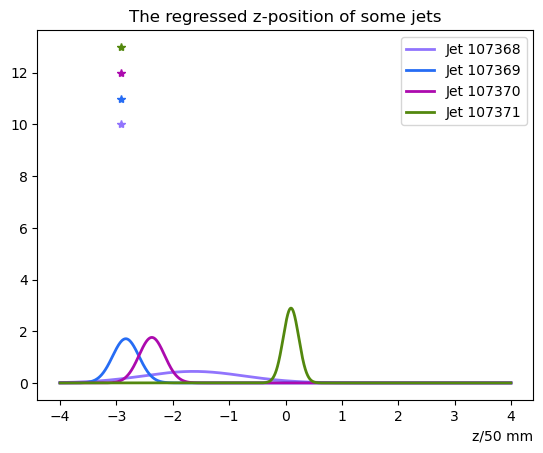

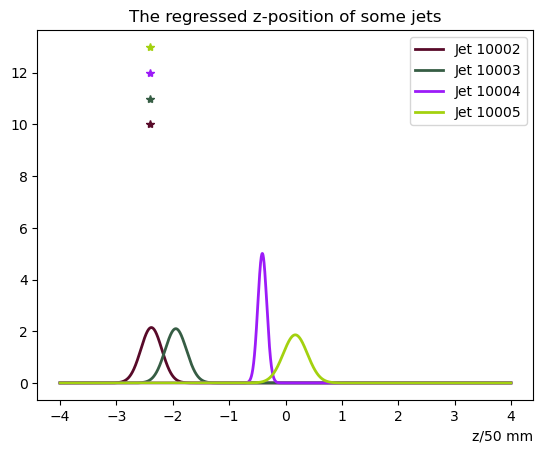

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

#Finding the events with 4 jets
uniques = np.unique(zhat)
c = 0
values = []
for value in uniques:
    if len(zhat[zhat == value]) == 4:
        values.append(value)

#print(np.where(zhat == values[0])[0][0])

#Plotting some events with 4 jets
for i in range(2): 
    x = np.arange(-4, 4, 0.001)
    ind_of_first = np.where(zhat == values[i])[0][0]
    n = np.arange(ind_of_first,ind_of_first+4,1)
    #Generating random colors for  the plot
    color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(len(n))]
    ic = 0      #color counter

    for i in n:
        plt.plot(x, norm.pdf(x, z[i], widths[i]), color=color[ic], linewidth=2, label='Jet '+str(i))
        plt.plot(zhat[i], 10 + ic, marker='*', color=color[ic])
        ic = ic + 1
    plt.xlabel("z/50 mm", loc='right')
    plt.title('The regressed z-position of some jets')
    plt.legend()
    plt.show()
    #plt.cla()

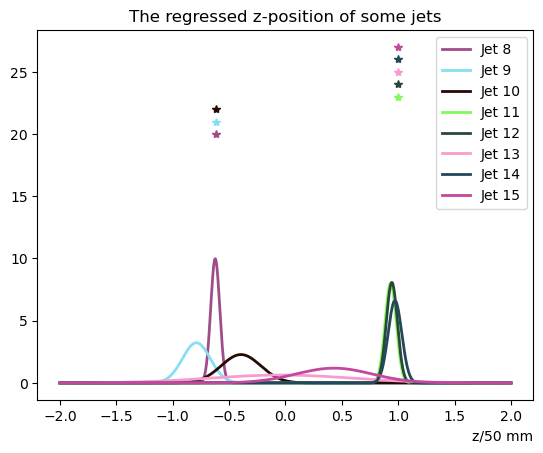

In [5]:
'''Plotting the jets' regressed z-position'''
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import random


#z-axis ranges from -2 and 2 with .001 steps
x = np.arange(-2, 2, 0.00001)
n = np.arange(8,16,1)

#Generating random colors for the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(len(n))]
ic = 0      #color counter

for i in n:
    plt.plot(x, norm.pdf(x, z[i], widths[i]), color=color[ic], linewidth=2, label='Jet '+str(i))
    plt.plot(zhat[i], ic + 20, marker='*', color=color[ic])
    ic = ic + 1
    """plt.plot(x, norm.pdf(x, z[6], widths[6]), color='red', linewidth=2, label='Second Jet')
    plt.plot(zhat[6], 11, marker='*', color="red")
    plt.plot(x, norm.pdf(x, z[7], widths[7]), color='green', linewidth=2, label='Third Jet')
    plt.plot(zhat[7], 12, marker='*', color="green")
    plt.plot(x, norm.pdf(x, z[8], widths[8]), color='orange', linewidth=2, label='Fourth Jet')
    plt.plot(zhat[8], 13, marker='*', color="orange")
    plt.plot(x, norm.pdf(x, z[9], widths[9]), color='purple', linewidth=2, label='Fifth Jet')
    plt.plot(zhat[9], 14, marker='*', color="purple")
    """
plt.xlabel("z/50 mm", loc='right')
plt.title('The regressed z-position of some jets')
plt.legend()
plt.show()
#plt.cla()

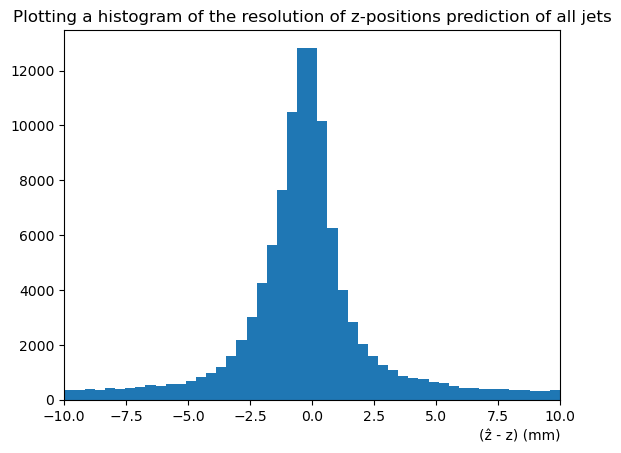

In [6]:
"""Plotting a histogram of the resolution of z-positions prediction of all jets"""
plt.hist((zhat-z)*50, bins=1000)
#plt.yscale('log')
plt.xlim(-10,10)
plt.title('Plotting a histogram of the resolution of z-positions prediction of all jets')
plt.xlabel("(z\u0302 - z) (mm)", loc='right')
plt.show()

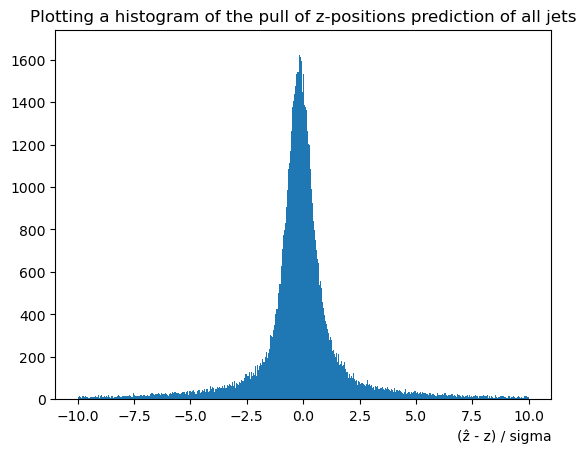

In [7]:
"""Plotting a histogram of the pull of z-positions prediction of all jets"""
plt.hist(((zhat-z)) / widths, bins=1000, range=(-10,10))
#plt.yscale('log')
#plt.xlim(-,250)
plt.title('Plotting a histogram of the pull of z-positions prediction of all jets')
plt.xlabel("(z\u0302 - z) / sigma", loc='right')
plt.show()

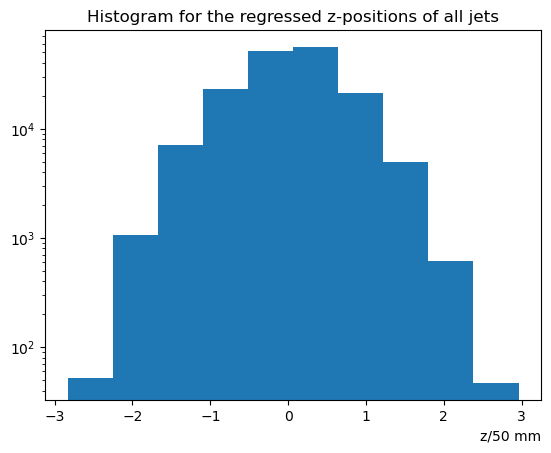

In [8]:
"""Plotting a histogram of the regressed z-positions of all jets"""
plt.hist(z, bins=10)
plt.yscale("log")
plt.title('Histogram for the '+ 'regressed z-positions' +' of all jets')
plt.xlabel("z/50 mm", loc='right')
plt.show()

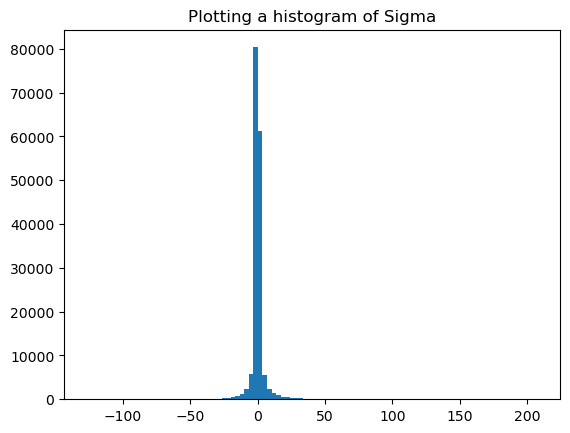

In [9]:
plt.hist(sigma, bins=100)
#plt.yscale('log')
plt.title('Plotting a histogram of Sigma')
plt.xlabel("", loc='right')
plt.show()

# Accessing the Dataset

In [10]:
from turtle import title
from h5py import File
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [48]:
#Opening the HDF5 File
input_file = "../user.maboelel.32438279._000005.output.h5"
data = File(input_file, 'r')

In [49]:
#Accessing the 'Jets' Dataset
print("List of available datasets: " + str(list(data.keys())))
jets = data['jets']

List of available datasets: ['jets', 'super_tracks', 'super_tracks_associated', 'super_tracks_fixed_cone']


In [50]:
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty'])


In [51]:
print("The number of jets in the sample is: " + str(len(jets)))
print("The number of jets in the sample with pT < 20 GeV is: " + str(len(jets[jets["pt"] < 20])))
print("The number of jets in the sample with eta > 2.5 GeV is: " + str(len(jets[jets["eta"] > 2.5])))

The number of jets in the sample ibs: 165789
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0


In [ ]:
%%time
# Getting an array of the jet multiplicities in the sample
uniques = np.unique(jets["eventNumber"])
jet_multiplicities = []
for i in uniques:
    jet_multiplicities.append(len(jets[jets["eventNumber"] == i]))

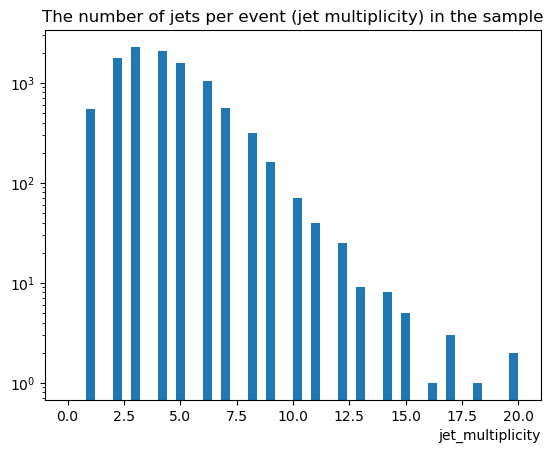

In [59]:
# Plotting the jet multiplicities in the sample
plt.hist(jet_multiplicities, bins = 50, range=(0,20))
plt.yscale('log')
plt.xlabel("jet_multiplicity", loc='right')
plt.title('The number of jets per event (jet multiplicity) in the sample')
plt.show()

In [18]:
%%time
# Getting an array of the leading jet pT's per event in the sample
leading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    leading_pT.append(max(pTs))

CPU times: user 37.8 s, sys: 1.05 s, total: 38.8 s
Wall time: 38.9 s


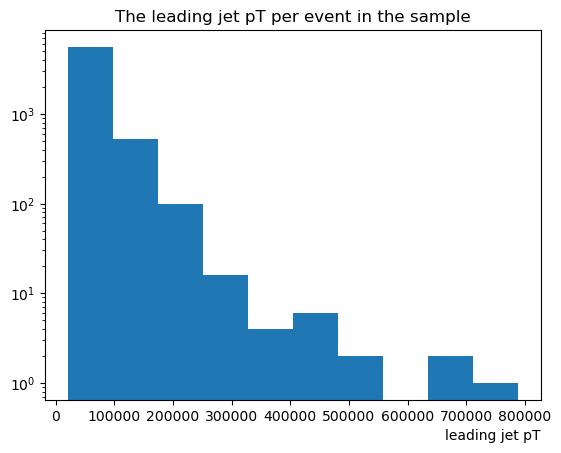

In [19]:
# Plotting the leading jet pT's per event in the sample
plt.hist(leading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("leading jet pT", loc='right')
plt.title('The leading jet pT per event in the sample')
plt.show()

In [20]:
%%time
# Getting an array of the sub-leading jet pT's per event in the sample
subleading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    if len(pTs) > 1: 
        subleading_pT.append(sorted(pTs)[-2])

CPU times: user 37.8 s, sys: 1.11 s, total: 38.9 s
Wall time: 38.9 s


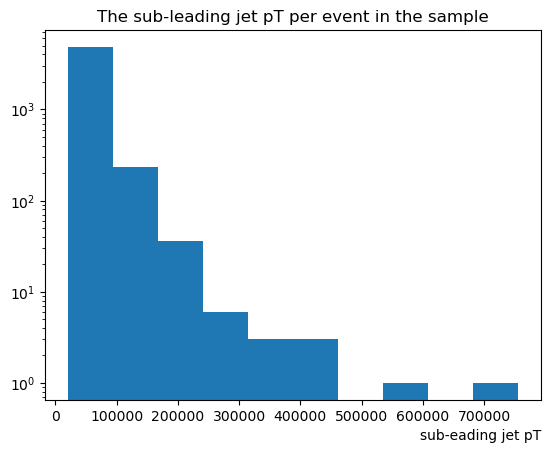

In [21]:
# Plotting the sub-leading jet pT's per event in the sample
plt.hist(subleading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("sub-eading jet pT", loc='right')
plt.title('The sub-leading jet pT per event in the sample')
plt.show()

In [22]:
%%time
# Getting an array of the third-leading jet pT's per event in the sample
thirdleading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    if len(pTs) > 2: 
        thirdleading_pT.append(sorted(pTs)[-2])

CPU times: user 37.9 s, sys: 1.09 s, total: 39 s
Wall time: 39 s


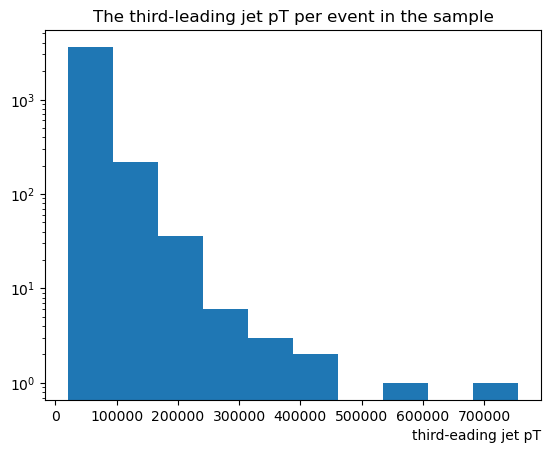

In [23]:
# Plotting the third-leading jet pT's per event in the sample
plt.hist(thirdleading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("third-eading jet pT", loc='right')
plt.title('The third-leading jet pT per event in the sample')
plt.show()

In [24]:
%%time
# Getting an array of the fourth-leading jet pT's per event in the sample
fourthleading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    if len(pTs) > 3: 
       fourthleading_pT.append(sorted(pTs)[-2])

CPU times: user 37.8 s, sys: 1.07 s, total: 38.9 s
Wall time: 38.9 s


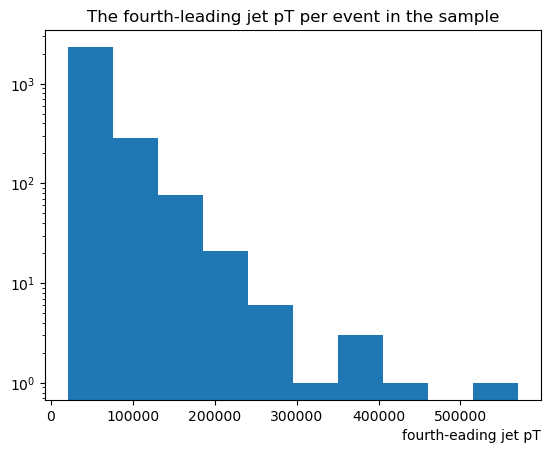

In [25]:
# Plotting the fourth-leading jet pT's per event in the sample
plt.hist(fourthleading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("fourth-eading jet pT", loc='right')
plt.title('The fourth-leading jet pT per event in the sample')
plt.show()

In [26]:
four_jet_ids = []
for i in uniques:
    if len(jets[jets["eventNumber"] == i]) == 4: 
        four_jet_ids.append(i)
        break;

In [27]:
four_jet_event = jets[jets["eventNumber"] == four_jet_ids[0]]
four_jet_event[0]["dipz20230223_z"]

-0.40256527

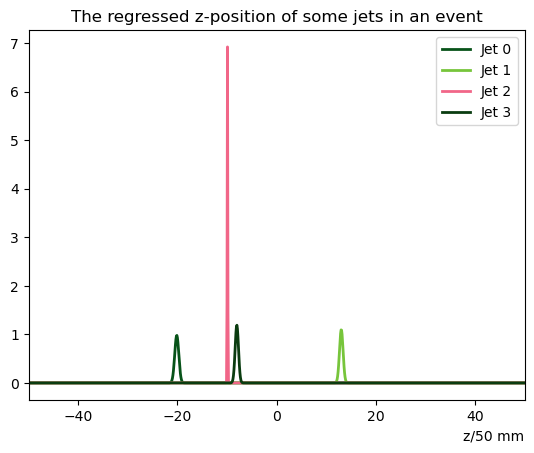

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
#Generating random colors for  the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(len(four_jet_event))]
ic = 0      #color counter

x = np.arange(-4*50, 4*50, 0.1)

for i in range(len(four_jet_event)):
    plt.plot(x, norm.pdf(x, four_jet_event[i]["dipz20230223_z"]*50, np.exp(-0.5*four_jet_event[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    ic = ic + 1    
plt.xlabel("z/50 mm", loc='right')
plt.title('The regressed z-position of some jets in an event')
plt.xlim([-1*50, 1*50])
plt.legend()
plt.show()
#plt.cla()

In [20]:
super_tracks = data['super_tracks']
print("The attributes of each element of the dataset (super_tracks): " + str(super_tracks.dtype.fields.keys()))

The attributes of each element of the dataset (super_tracks): dict_keys(['numberOfInnermostPixelLayerHits', 'numberOfNextToInnermostPixelLayerHits', 'numberOfPixelHits', 'numberOfSCTHits', 'numberOfPixelHoles', 'numberOfSCTHoles', 'chiSquared', 'numberDoF', 'radiusOfFirstHit', 'qOverP', 'pt', 'ptfrac', 'qOverPUncertainty', 'd0', 'd0Uncertainty', 'IP2D_signed_d0', 'phiUncertainty', 'thetaUncertainty', 'deta', 'dphi', 'dr', 'z0RelativeToBeamspot', 'z0RelativeToBeamspotUncertainty', 'valid'])


In [21]:
print(super_tracks['z0RelativeToBeamspot'])

[[ 37.13629    37.253117   40.838814  ...         nan         nan
          nan]
 [-30.690022   38.180237   50.051197  ...         nan         nan
          nan]
 [  5.6123476 -24.55395   -33.712482  ...         nan         nan
          nan]
 ...
 [  7.3150687  26.28233    12.656669  ...         nan         nan
          nan]
 [  9.174093    9.1709385   9.12646   ...         nan         nan
          nan]
 [-57.978844   60.228466   -8.469741  ...         nan         nan
          nan]]


In [29]:
print(np.sum(jets['n_super_tracks'] == 0))

2


In [30]:
print(len(jets))

116


In [31]:
print(z.shape)

(116,)


In [32]:
print(jets)

<HDF5 dataset "jets": shape (116,), type "|V92">


In [33]:
print(z[0])

0.74848443


In [34]:
print(jets['dipz20230223_z'][0])

0.7484845


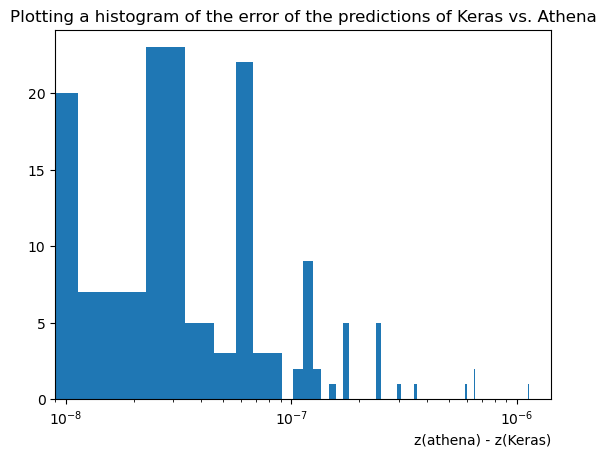

In [35]:
plt.hist(np.abs(jets['dipz20230223_z']-z), bins=100)
plt.xscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

2


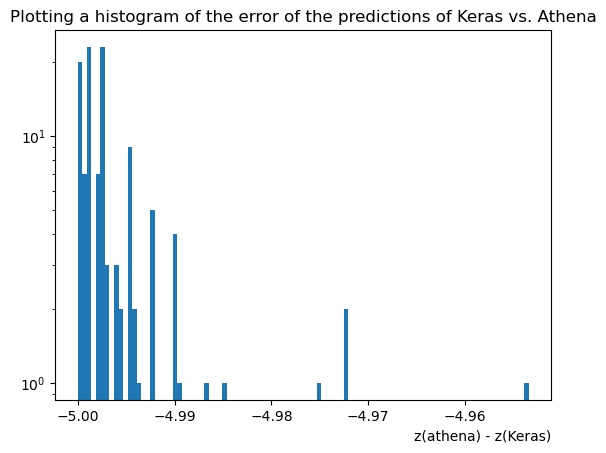

In [36]:
سين = 2
print(سين)
plt.hist(np.log10(np.abs(jets['dipz20230223_z']-z) + 10**-5), bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

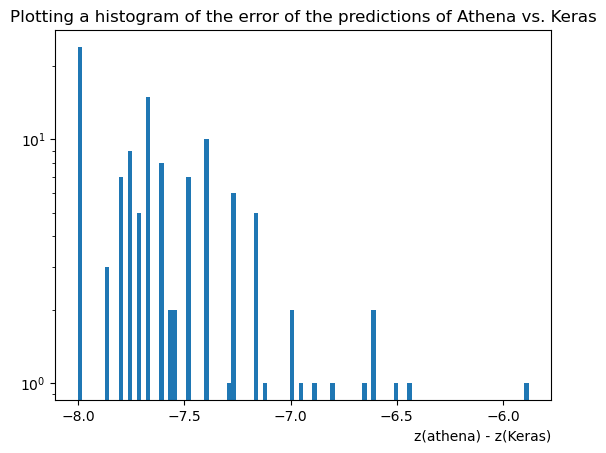

In [37]:
c = np.sqrt(np.exp(-jets['dipz20230223_negLogSigma2']))-widths
plt.hist(np.log10(np.abs(c) + 10**-8), bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Athena vs. Keras')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

In [39]:
c2 = np.sqrt(np.exp(-jets['dipz_negLogSigma2']))-widths
plt.hist(c2, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the Uncertainty of Athena vs. Keras')
plt.xlabel("std(athena) - std(Keras)", loc='right')
plt.show()

ValueError: Field dipz_negLogSigma2 does not appear in this type.

In [ ]:
jets['dipz20230223_z'].mean()

In [ ]:
plt.hist(jets['dipz20230223_z'], bins=100)
#plt.yscale('log')
plt.show()

In [ ]:
plt.hist(zhat, bins=100)
#plt.yscale('log')
plt.show()

In [ ]:
plt.hist(jets['dipz20230223_z']-zhat, bins=100)
plt.yscale('log')
plt.show()

In [ ]:
"""Plotting a histogram of the error of z-positions predictionof all jets"""
plt.hist(zhat-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of z-positions prediction of all jets')
plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

In [ ]:
plt.hist(jets['dipz20230223_z']-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions')
#plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

In [ ]:
d = jets['dipz20230223_z']-z
c = d > 0.01 
print(len(d))
print(np.count_nonzero(c))

In [ ]:
regions = [1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10]
for i in regions:
    c = c1 > i 
    n = np.count_nonzero(c)
    print("The number of predictions with error in calculating z bigger than " + str(i) + " is " + str(n))

In [ ]:
s = jets['dipz20230223_negLogSigma2']-widths
max = np.argmax(s)

In [ ]:
jet_intended = jets[max]
jet_variables = ['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 
                 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 
                 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 
                 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 
                 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 
                 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty']
for var in jet_variables:
    c = jet_intended[var]
    print("The jet's " + var + " is " + str(c))

In [ ]:
idx = jets['n_super_tracks'] < 40
c = jets['dipz20230223_z']-z
plt.hist(np.log10(np.abs(c[idx])+ 1e-10) , bins=500)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

In [ ]:
plt.hist(jets['primaryVertexDetectorZ'], bins=100)
#plt.yscale('log')
plt.show()

In [ ]:
j = jets['primaryVertexDetectorZ'].astype('float64')
print("The target's mean is: " + str(j.mean()))
print("The target's std is: " + str(j.std()))